Materia: Ciencia de Datos\
Alumno: Francisco López Tancredi\
Padrón: 110464\
Fecha de Entrega: 19-06-2025

# **Parte 2:** Machine Learning Baseline

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores hiperparámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 300}

Accuracy : 0.9184
ROC-AUC  : 0.9665

              precision    recall  f1-score   support

           0      0.935     0.879     0.906        66
           1      0.906     0.951     0.928        81

    accuracy                          0.918       147
   macro avg      0.921     0.915     0.917       147
weighted avg      0.919     0.918     0.918       147


Archivo submission_rf.csv generado.


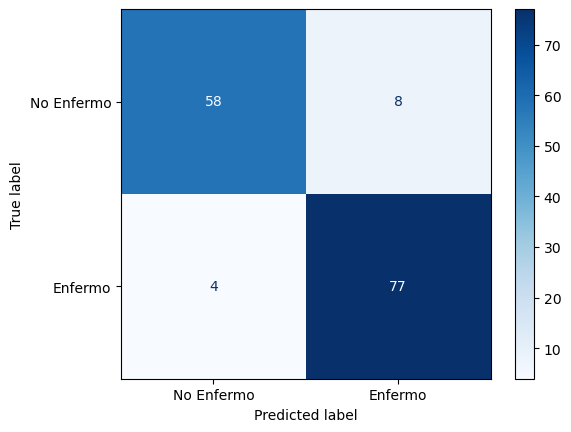

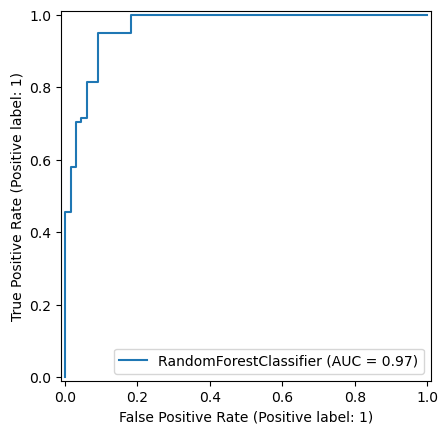

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, RocCurveDisplay
)

RANDOM_STATE = 1           # reproducibilidad en todos lados
TRAIN_PATH   = Path("heart_train.csv")
TEST_PATH    = Path("heart_test.csv")   # si no existe, se salta la parte de submission

# 1. -------------------   CARGA Y SANEAMIENTO
df = pd.read_csv(TRAIN_PATH)

# Imputación simple: Cholesterol == 0 → mediana no-cero
chol_median = df.loc[df["Cholesterol"] != 0, "Cholesterol"].median()
df.loc[df["Cholesterol"] == 0, "Cholesterol"] = chol_median

# 2. -------------------   ONE-HOT ENCODING
y = df["HeartDisease"]
X = pd.get_dummies(df.drop(columns=["HeartDisease"]), drop_first=True)

# 3. -------------------   SPLIT TRAIN / VALID ESTRATIFICADO
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

# 4. -------------------   RANDOM FOREST + GRID SEARCH
param_grid = {
    "n_estimators":    [300, 600, 900],
    "max_depth":       [None, 15, 25],
    "min_samples_leaf":[1, 2, 4],
    "max_features":    ["sqrt", 0.5, None],
}
rf_base = RandomForestClassifier(
    random_state=RANDOM_STATE, n_jobs=-1
)

skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

gs = GridSearchCV(
    rf_base,
    param_grid,
    cv=skf,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)
gs.fit(X_train, y_train)

best_rf = gs.best_estimator_
print(f"Mejores hiperparámetros: {gs.best_params_}")

# 5. -------------------   EVALUACIÓN EN VALIDACIÓN
y_pred      = best_rf.predict(X_valid)
y_proba     = best_rf.predict_proba(X_valid)[:, 1]
acc         = accuracy_score(y_valid, y_pred)
roc_auc     = roc_auc_score(y_valid, y_proba)
print(f"\nAccuracy : {acc:0.4f}")
print(f"ROC-AUC  : {roc_auc:0.4f}\n")

print(classification_report(y_valid, y_pred, digits=3))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_rf, X_valid, y_valid,
    display_labels=["No Enfermo", "Enfermo"],
    cmap="Blues"
)

# Curva ROC
RocCurveDisplay.from_estimator(best_rf, X_valid, y_valid)

# 6. -------------------   ENTRENAMIENTO FINAL Y SUBMISSION
if TEST_PATH.exists():
    # Repetir imputación y encoding sobre el test
    test_df = pd.read_csv(TEST_PATH)
    test_df.loc[test_df["Cholesterol"] == 0, "Cholesterol"] = chol_median
    X_test = pd.get_dummies(test_df, drop_first=True)

    # Cuadrar columnas: asegurar que X_test tiene mismo orden/columnas que X
    X_test = X_test.reindex(columns=X.columns, fill_value=0)

    best_rf.fit(X, y)                     # full-train
    test_proba = best_rf.predict_proba(X_test)[:, 1]

    submission = pd.DataFrame({
        "id": np.arange(len(test_proba)),  # ajustalo si tu test tiene otro id
        "HeartDisease": test_proba
    })
    submission.to_csv("submission_rf.csv", index=False)
    print("\nArchivo submission_rf.csv generado.")
else:
    print("\nNo se encontró heart_test.csv → se omitió la parte de submission.")


El objetivo de esta sección es construir un modelo sencillo de Machine Learning, usando todas las columnas del dataset para entrenar una **regresión logística**, incluyendo:
- Encoding de variables categóricas.
- Búsqueda de hiperparámetros.
- Reproducibilidad de resultados garantizada.

Primero se importan todas las **librerías** necesarias para el análisis y se carga el archivo `heart_train.csv` en un **DataFrame**.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, confusion_matrix, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from scipy.stats import loguniform

In [2]:
df = pd.read_csv('heart_train.csv')

En el análisis exploratorio se observó que algunos valores del atributo `Cholesterol` son 0. Esto es algo que no tiene sentido, y representan `NaN`. Por lo tanto, deben ser reemplazados con algún valor. Primero se consideró la media, pero ésta está influida por valores extremos. En cambio, se decide pisar el 0 con la mediana, ya que indica el punto medio.

In [3]:
chol_median = df.loc[df['Cholesterol'] != 0, 'Cholesterol'].median()
df.loc[df['Cholesterol'] == 0, 'Cholesterol'] = chol_median

Una vez hecho esto, se divide el DataFrame en:
- `X`: la **variable predictora**.
- `y`: la **variable objetivo** (`HeartDisease`).

Y luego se subdividirán nuevamente con la función `test_train_split` en: `X_train`, `X_test`, `y_train`, `y_test`; donde las variables train se usarán para **entrenar** el modelo, y las otras para **testearlo**.

Además se distinguen las columnas del DataFrame categóricas y aquellas numéricas, para luego procesarlas de la siguiente manera:
- Para las columnas categóricas, se **encodearán** usando One-Hot Encoding. Se elige este encoder debido al bajo número de valores distintos que puede tener un atributo. De las 6 variables categóricas: 3 son binarias, 2 tienen tres valores distintos, y 1 tiene hasta 4 valores.
- Para las columnas numéricas, se **escalarán** para que todas queden con media cero y desvío estándar uno. 

In [4]:
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [5]:
categorical = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numerical = [col for col in X.columns if col not in categorical]

In [6]:
X = pd.get_dummies(X, columns=categorical, drop_first=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [8]:
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.transform(X_test[numerical])

A continuación se definirán los **hiperparámetros** a buscar con `RandomSearchCV`. Se usará también validación cruzada (**cross-validation**) de 5 folds.

In [9]:
param_dist = {
    'C': loguniform(1e-2, 1e1),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
search = RandomizedSearchCV(
    estimator = LogisticRegression(max_iter=1000, random_state=42),
    param_distributions = param_dist,
    n_iter = 20,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = cv,
    random_state=42,
)

Finalmente, se ajusta la búsqueda al conjunto de entrenamiento y se imprimen los resultados principales.

In [18]:
search.fit(X_train, y_train)

print(f"Puntuación media de validación cruzada del mejor estimador: {search.best_score_:.4f}")
print(f"Mejores hiperparámetros: \n  {search.best_params_}")

Puntuación media de validación cruzada del mejor estimador: 0.8450
Mejores hiperparámetros: 
  {'C': np.float64(0.13292918943162169), 'penalty': 'l1', 'solver': 'liblinear'}


Habiendo encontrado entonces el mejor modelo, se procede a evaluarlo con las métricas: accuracy, ROC-AUC, precision y recall.

In [20]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

In [21]:
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
precision_0 = precision_score(y_test, y_pred, pos_label=0)
precision_1 = precision_score(y_test, y_pred, pos_label=1)
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

print(f"Accuracy score: {acc:.4f}")
print(f"ROC-AUC score: {auc:.4f}")
print(f"Precision '0': {precision_0:.4f}")
print(f"Precision '1': {precision_1:.4f}")
print(f"Recall '0': {recall_0:.4f}")
print(f"Recall '1': {recall_1:.4f}")

Accuracy score: 0.9252
ROC-AUC score: 0.9620
Precision '0': 0.9231
Precision '1': 0.9268
Recall '0': 0.9091
Recall '1': 0.9383


A su vez, se muestra la matriz de confusión, que muestra:
- La cantidad de pacientes que fueron clasificados correctamente como "No Enfermo" (60).
- La cantidad de pacientes que fueron clasificados correctamente como "Enfermo" (76).
- La cantidad de pacientes que fueron clasificados incorrectamente como "No Enfermo" (5).
- La cantidad de pacientes que fueron clasificados incorrectamente como "Enfermo" (6).

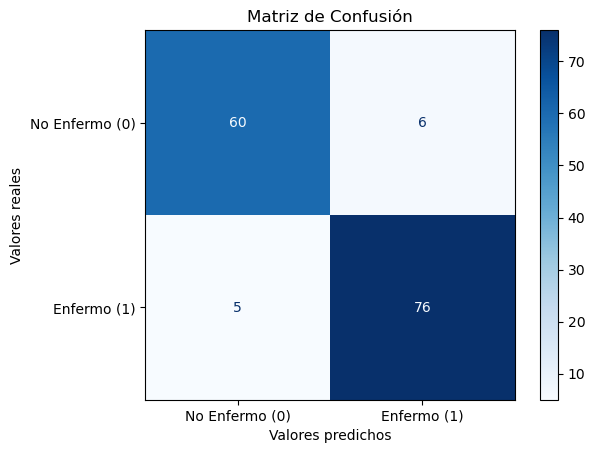

In [39]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, display_labels=['No Enfermo','Enfermo'], cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')
plt.xticks([0, 1], ['No Enfermo (0)', 'Enfermo (1)'])
plt.yticks([0, 1], ['No Enfermo (0)', 'Enfermo (1)'])
plt.show()

Y también el gráfico de la **curva ROC**, que muestra:
- En el eje $x$, la tasa de falsos positivos
- En el eje $y$, la tasa de verdaderos positivos.

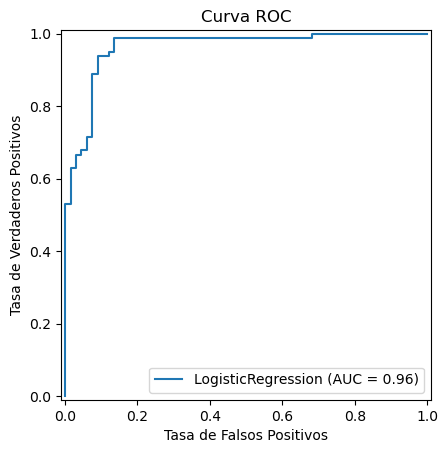

In [40]:
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title('Curva ROC')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.show()

Finalmente, usando el modelo encontrado se muestra la **importancia de los features**. Para esto, se obtiene cada feature con su coeficiente y se arma un DataFrame para mostrar los valores ordenados.

In [33]:
pd.DataFrame({
    'feature': X_test.columns,
    'coef':    best_model.coef_[0]
}).sort_values(by='coef', key=abs, ascending=False)

,feature,coef
14,ST_Slope_Up,-1.378219
7,ChestPainType_NAP,-0.785669
6,ChestPainType_ATA,-0.780950
5,Sex_M,0.764544
12,ExerciseAngina_Y,0.754404
9,FastingBS_1,0.611965
3,MaxHR,-0.343452
13,ST_Slope_Flat,0.279232
4,Oldpeak,0.213478
2,Cholesterol,0.000000


Por lo tanto, se observa que:
- Una pendiente ST ascendente se asocia a un menor riesgo de enfermedad cardíaca.
- Cuando los dolores son `NAP` (Dolor no anginal) o `ATA` (Angina atípica), el riesgo es menor respecto a los otros tipos de dolores.
- El riesgo de enfermedad cardíaca parece ser mayor en **hombres**.
- Un nivel alto de **azúcar en sangre en ayunas** incrementa el riesgo de enfermedad cardíaca.

En conclusión, se construyó un **baseline de regresión logística** para la predicción de enfermedad cardíaca usando todos los atributos del set de datos. Mediante un **RandomizedSearchCV** con 5-folds estratificados, se obtuvo un modelo resultante, cuya evaluación determinó los siguientes valores:
- **Accuracy:** 0.9252.
- **ROC-AUC:** 0.9620.
- **Precisión y recall por clase:**
  - Clase "No Enfermo" (0): 0.9231 y 0.9091 respectivamente.
  - Clase "Enfermo" (1): 0.9268 y 0.9383 respectivamente.

Evaluando los coeficientes del modelo, se observó la **importancia de los features**, y se comentó acerca de sus resultados.